# Calibration

In [1]:
import random

from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
import torch
import wandb

from calibration import data
from calibration import dist
from calibration import method
from calibration import pit
from calibration import plot

In [2]:
def param2pdf(weight, mean, variance):
    return lambda x: dist.pdf_gaussian_mixture(x, weight, mean, variance)

def y2pdf(w, s, v1, v2):
    weight = torch.tensor([w, 1 - w])
    mean = torch.tensor([-s / 2, s / 2])
    variance = torch.tensor([v1, v2])
    return param2pdf(weight, mean, variance)

## Interpreter

In [3]:
checkpoint = torch.load("models/eternal-smoke-51.pt")
hyperparams = checkpoint["hyperparams"]
interpreter = method.MDN(inputs=hyperparams["bins"],
                neurons=hyperparams["neurons"],
                components=hyperparams["components"])
interpreter.load_state_dict(checkpoint["model_state_dict"])
interpreter

MDN(
  (linear1): Linear(in_features=20, out_features=16, bias=True)
  (linear2): Linear(in_features=16, out_features=15, bias=True)
)

## Synthetic data set

In [4]:
TESTS = 1000
torch.manual_seed(78)
testset = pit.PITDataset(TESTS)

In [5]:
refset = pit.PITReference()
len(refset)

625

In [6]:
pred_mdn = method.predict(interpreter, testset.X)

In [7]:
random.seed(54)
random.sample(range(len(testset)), k=3)

[935, 140, 449]

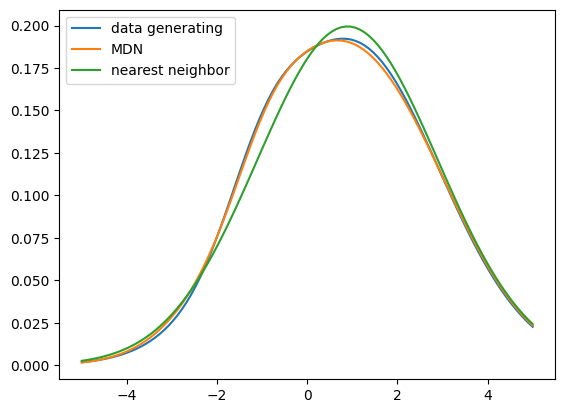

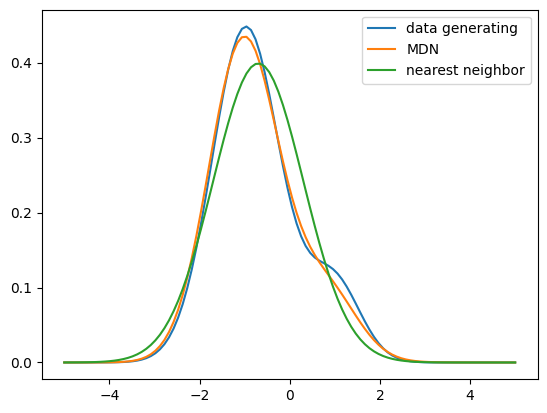

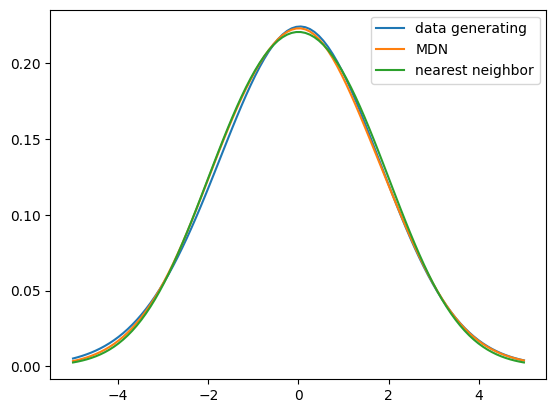

In [8]:
distances = euclidean_distances(testset.X, refset.X)
js = distances.argmin(axis=1)
random.seed(54)
for i in random.sample(range(len(testset)), k=3):
    y = testset.annotation[i]
    weight = pred_mdn[0][i]
    mean = pred_mdn[1][i]
    variance = pred_mdn[2][i]
    neighbour = refset.annotation[js][i]
    _, ax = plt.subplots()
    plot.density(ax, y2pdf(*y), label="data generating")
    plot.density(ax, param2pdf(weight, mean, variance), label="MDN")
    plot.density(ax, y2pdf(*neighbour), label="nearest neighbor")
    ax.legend()
    plt.show()
    plt.close()

In [9]:
nll_mdn = dist.nll_gaussian_mixture(testset.y, *pred_mdn).mean()
nll_mdn.item()

1.5751768350601196

 5 1.594929 625
 6 1.588798 1296
 7 1.584703 2401
 8 1.582518 4096
 9 1.580026 6561
10 1.579281 10000
11 1.577954 14641
12 1.577489 20736
13 1.577056 28561
14 1.576665 38416
15 1.576427 50625
16 1.576242 65536
17 1.576090 83521


[1.5949293375015259,
 1.5887978076934814,
 1.5847026109695435,
 1.5825175046920776,
 1.5800261497497559,
 1.5792814493179321,
 1.5779544115066528,
 1.5774885416030884,
 1.5770559310913086,
 1.5766645669937134,
 1.5764267444610596,
 1.5762418508529663,
 1.576089859008789]

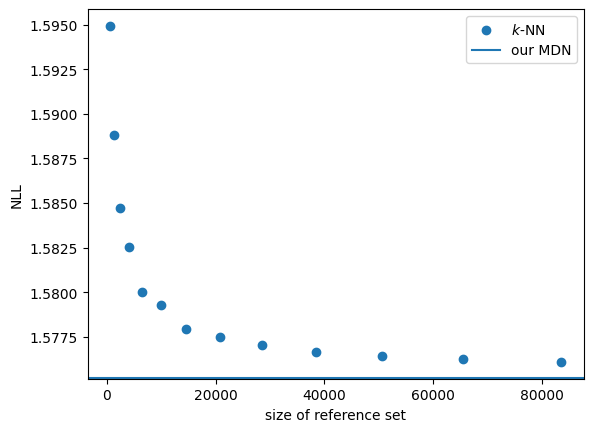

In [10]:
steps = range(5, 18)
nll_neighbour = []
for s in steps:
    refset = pit.PITReference(steps=s)
    distances = euclidean_distances(testset.X, refset.X)
    js = distances.argmin(axis=1)
    neighbour = refset.annotation[js]
    weight = torch.stack([neighbour[:, 0], 1 - neighbour[:, 0]], dim=1)
    mean = torch.stack((-neighbour[:, 1] / 2, neighbour[:, 1] / 2), dim=1)
    variance = neighbour[:, 2:]
    nll = dist.nll_gaussian_mixture(testset.y, weight, mean, variance)
    nll_neighbour.append(nll.mean().item())
    print(f"{s:2d} {nll_neighbour[-1]:f} {s ** 4}")

_, ax = plt.subplots()
size = [s ** 4 for s in steps]
ax.scatter(size, nll_neighbour, label="$k$-NN")
ax.axhline(nll_mdn, label="our MDN")
ax.set_xlabel("size of reference set")
ax.set_ylabel("NLL")
ax.legend()
nll_neighbour

In [11]:
df = pd.DataFrame.from_dict({"steps": steps,
                             "size": size,
                             "nll": nll_neighbour})
df = df.set_index("steps")
df.to_csv("data/neighbour.csv")
df

,size,nll
steps,,
5,625,1.594929
6,1296,1.588798
7,2401,1.584703
8,4096,1.582518
9,6561,1.580026
10,10000,1.579281
11,14641,1.577954
12,20736,1.577489
13,28561,1.577056


## Uniform PIT histogram

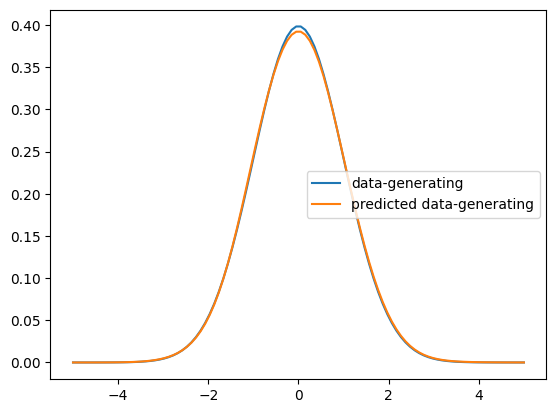

In [12]:
pit_hist_uniform = torch.full((pit.BINS, ), 1.0)
pred_uniform = method.predict(interpreter, pit_hist_uniform)
_, ax = plt.subplots()
plot.density(ax, dist.pdf_gaussian, label="data-generating")
plot.density(ax, param2pdf(*pred_uniform), label="predicted data-generating")
ax.legend()

## UCI ML repository data sets

In [13]:
def load_model(modelfile, Model, keys):
    checkpoint = torch.load(modelfile)
    hyperparams = checkpoint["hyperparams"]
    model = Model(*[hyperparams[k] for k in ("inputs", "neurons") + keys])
    model.load_state_dict(checkpoint["model_state_dict"])
    return model

def load_mdn(modelfile):
    return load_model(modelfile, method.MDN, ("components", ))

def load_dn(modelfile):
    return load_mdn(modelfile)

def load_de(modelfile):
    return load_model(modelfile, method.DE, ("members", ))

def plot_interpretation(ax, interpretation):
    plot.density(ax, dist.pdf_gaussian, label="predictive")
    plot.density(ax, param2pdf(*interpretation), label="predicted data-generating")
    ax.legend()

def pit_hist(model, dataset):
    alpha, mu, sigma = method.predict(model, dataset.X)
    pit_values = pit.pit_gaussian_mixture(dataset.y, alpha, mu, sigma)
    return pit.pit_hist(pit_values)

def diagnose(pit_hist, interpreter=interpreter):
    interpretation = method.predict(interpreter, pit_hist)
    pit_hist_interpreter = pit.pit_hist(pit.pit_gaussian(dist.sample_gaussian_mixture(*interpretation)))
    _, (ax1, ax2) = plt.subplots(nrows=2)
    plot_interpretation(ax1, interpretation)
    plot.pit_hist(ax2, pit_hist, label="true")
    plot.pit_hist(ax2, pit_hist_interpreter, label="predicted")
    ax2.legend()

### Metrics

In [14]:
api = wandb.Api()
runs = api.runs("podondra/calibration")

keys = ["dataname", "method", "seed", "neurons"]
dicts, names = [], []
for run in runs:
    try:
        dictionary = {k: run.config[k] for k in keys}
        dictionary["nll"] = run.summary["test.nll"]
        dictionary["crps"] = run.summary["test.crps"]
    except KeyError:
        continue
    dicts.append(dictionary)
    names.append(run.name)

df = pd.DataFrame(data=dicts, index=names)
gdf = df.groupby(["dataname", "method"])
df

,dataname,method,seed,neurons,nll,crps
whole-planet-49,protein,de,15,100,2.688056,2.210364
colorful-pyramid-48,protein,de,9,100,2.703884,2.099502
worthy-blaze-46,protein,de,8,100,2.682899,2.274802
sleek-wood-46,protein,de,7,100,2.585679,2.193159
peachy-sponge-45,year,de,15,100,3.365911,4.296823
earthy-shape-44,year,de,9,100,3.375157,4.340910
fanciful-plasma-43,year,de,8,100,3.355052,4.252754
clear-sea-42,year,de,7,100,3.372073,4.299245
desert-breeze-41,year,mdn,15,100,3.094955,4.036980
silvery-universe-40,year,mdn,9,100,3.091838,4.048255


In [15]:
gdf["nll"].agg(["mean", "sem"])

mean       sem
dataname method                    
power    de      2.808961  0.016763
         dn      2.794552  0.017980
         mdn     2.672990  0.022673
protein  de      2.674714  0.022905
         dn      2.804612  0.039376
         mdn     2.085908  0.016889
year     de      3.366982  0.003437
         dn      3.372904  0.003265
         mdn     3.093512  0.001768

In [16]:
gdf["crps"].agg(["mean", "sem"])

mean       sem
dataname method                    
power    de      2.125439  0.031547
         dn      2.175104  0.030190
         mdn     2.092784  0.042207
protein  de      2.196378  0.028107
         dn      2.341886  0.024816
         mdn     1.939665  0.019076
year     de      4.293765  0.014421
         dn      4.322462  0.013480
         mdn     4.039576  0.007017

### Power

In [17]:
_, _, powerset = data.split(*data.power(), seed=4)

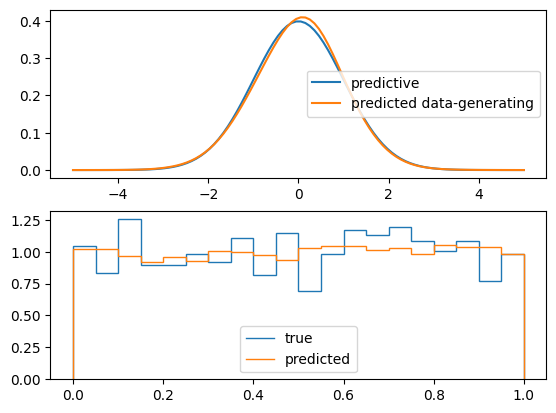

In [18]:
pit_hist_dn_power = pit_hist(load_dn("models/polished-star-1.pt"), powerset)
diagnose(pit_hist_dn_power)

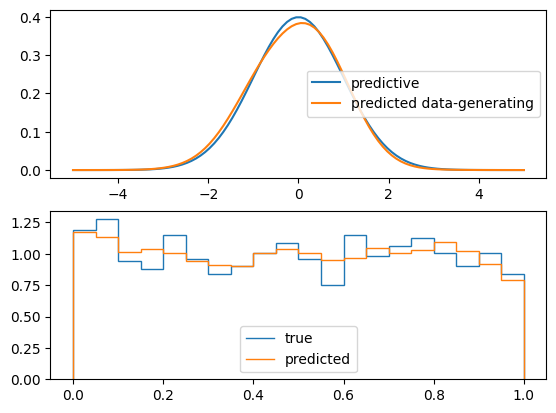

In [19]:
pit_hist_de_power = pit_hist(load_de("models/elated-surf-3.pt"), powerset)
diagnose(pit_hist_de_power)

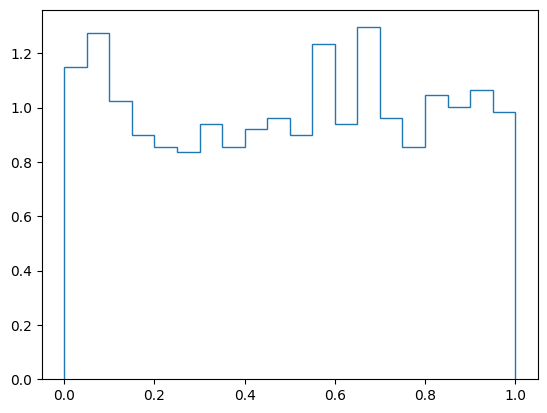

In [20]:
pit_hist_mdn_power = pit_hist(load_mdn("models/effortless-firefly-2.pt"), powerset)
plot.pit_hist(plt.subplots()[1], pit_hist_mdn_power)

### Protein

In [21]:
_, _, proteinset = data.split(*data.protein(), seed=4)

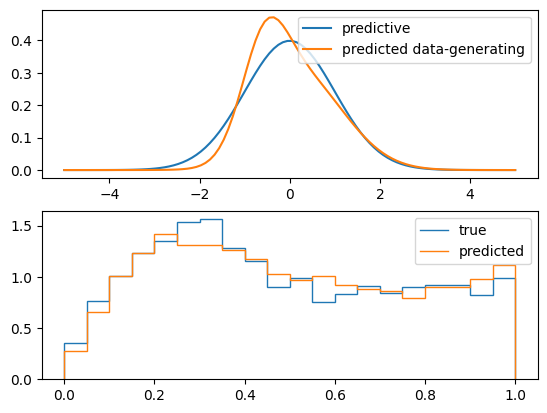

In [22]:
pit_hist_dn_protein = pit_hist(load_dn("models/super-durian-4.pt"), proteinset)
diagnose(pit_hist_dn_protein)

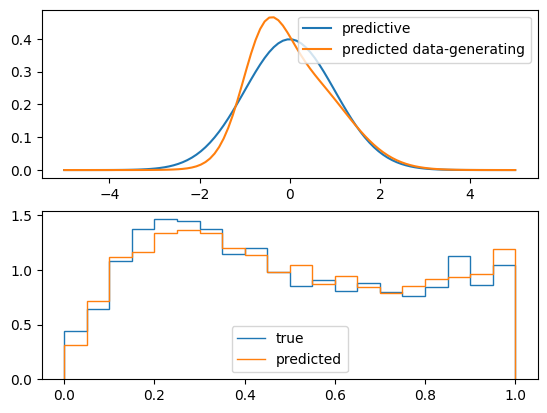

In [23]:
pit_hist_de_protein = pit_hist(load_de("models/golden-snow-6.pt"), proteinset)
diagnose(pit_hist_de_protein)

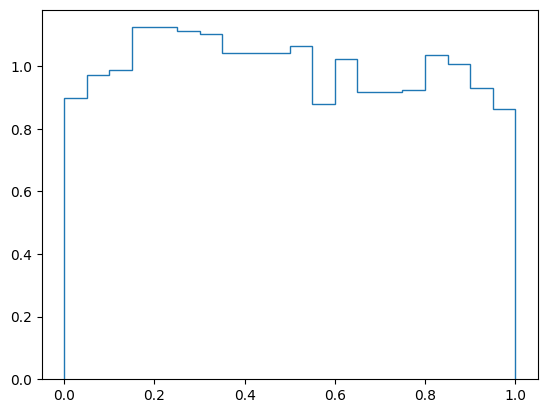

In [24]:
pit_hist_mdn_protein = pit_hist(load_mdn("models/lucky-moon-5.pt"), proteinset)
plot.pit_hist(plt.subplots()[1], pit_hist_mdn_protein)

### Year

In [25]:
_, _, yearset = data.split(*data.year(), seed=4)

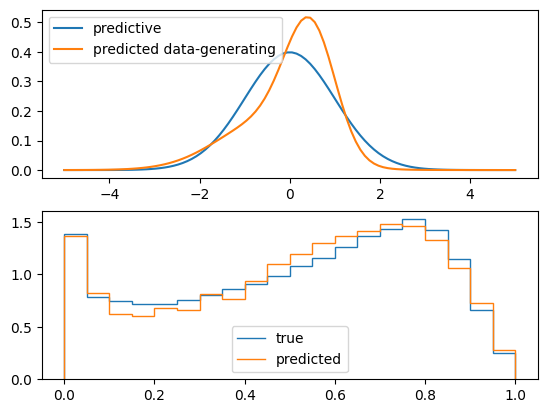

In [26]:
pit_hist_dn_year = pit_hist(load_dn("models/rich-dragon-8.pt"), yearset)
diagnose(pit_hist_dn_year)

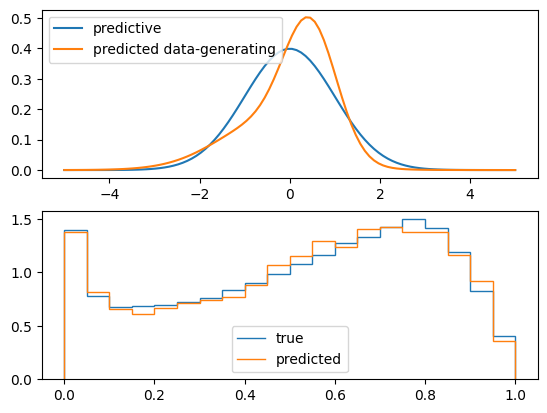

In [27]:
pit_hist_de_year = pit_hist(load_de("models/generous-valley-7.pt"), yearset)
diagnose(pit_hist_de_year)

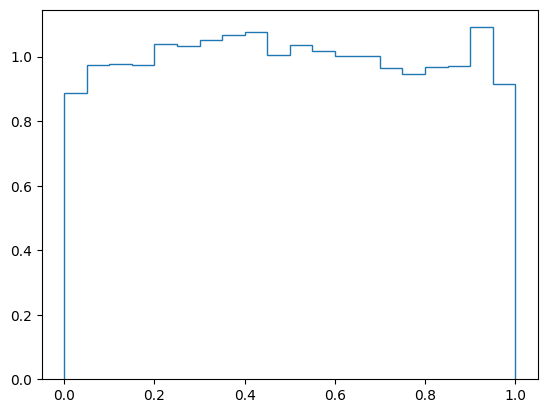

In [28]:
pit_hist_mdn_year = pit_hist(load_mdn("models/chocolate-sound-9.pt"), yearset)
plot.pit_hist(plt.subplots()[1], pit_hist_mdn_year)